# $P(n)$: Multivariate Model Mixing 

## Alexandra Semposki

### Date last edited: 30 January 2024

We would like to model mix the chiral EFT EOS with the perturbative QCD EOS for Symmetric Nuclear Matter (SNM) using an interpolant between the two regions of model validity. First we set up the two models as `dict`s and then we employ a simple Gaussian Process (GP) to handle the interpolation between the two.

#### Table of contents

1. [Bayesian Model Mixing via Taweret](#bmm_taweret)
  1. [Speed of sound calculaton](#cs2_taweret)
1. [Bayesian Model Mixing as a GP](#bmm_gp) 
  1. [Speed of sound calculation](#cs2_gp)

__NOTE__: Anywhere you see '!!!' in the comments, those are sections under construction that need cleaning up.

# STOP. 

Have you checked that you're on the correct branch of Taweret?

In [13]:
# import packages
%load_ext autoreload
%autoreload 2

import gsum as gm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.integrate as scint
import scipy.interpolate as scinterp
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator
import scipy.stats as stats
import os
import sys
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize as opt
import pandas as pd
from collections import defaultdict
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# import Taweret
import sys
sys.path.append('../../Taweret')  # Taweret needs to be a pip package (I know, work in progress)
sys.path.append('src/')
sys.path.append('data/')

# import from Taweret all modules
from Taweret.core.base_model import BaseModel
from Taweret.mix.gaussian import Multivariate

In [15]:
# import plotting script from J. Melendez
from scripts import *
setup_rc_params()

In [16]:
# import classes for chiral and pQCD
from chiral_model import Chiral_model
from pqcd_reworked import PQCD
from gorda_model import Gorda

# import class to wrap gsum
from truncation_error import Truncation

# import class for speed of sound calculation
from utils import speed_of_sound

## Bayesian Model Mixing via Taweret <a id="bmm_taweret"></a>

### Training data and model evaluations

Here the models are both evaluated at every training and testing point we'll be using, so that we can save this data and pick the proper training points and testing points for the GP later on.

In [17]:
# make it easier and simply combine models pointwise and write the classes here

# define density linspace for training and testing
density = np.linspace(0.05, 16.0, 600)
n0 = 0.16 

# chiral
class ChiralModel(BaseModel):
    
    def __init__(self, density):    
        
        # import the data set here
        chiral_data = np.load('data/eos_data/pressure_chiral_data_scaled_cpk_mean.npz')
        self.dens_test = chiral_data['density']
        self.mean_test = chiral_data['mean'][:,3]
        self.std_test = chiral_data['std_dev'][:,3]
        
        # check density to match
        print(np.allclose(density,self.dens_test))
                
        return None
    
    # mean and std here imported from data set
    def evaluate(self, density):
        
        # return the arrays for mixing from the GP
        return self.mean_test, self.std_test
    
    # define prior function
    def set_prior(self):       
        return None 
    
    # define likelihood
    def log_likelihood_elementwise(self):       
        return None
    
# instantiate chiral model here
chiral_eos = ChiralModel(density)
mean_chiral, std_dev_chiral = chiral_eos.evaluate(density)

# pqcd
class PQCDModel(BaseModel):
    
    def __init__(self, density): 
        
        # import the data set here
        pqcd_data = np.load('data/eos_data/pressure_pqcd_data_scaled.npz')
        self.dens_test = pqcd_data['density']
        self.mean_test = pqcd_data['mean'][:,2]
        self.std_test = pqcd_data['std_dev'][:,2]
        
        # check density to match
        print(np.allclose(density,self.dens_test))
                
        return None
    
    # mean and std here imported from data set
    def evaluate(self, density):
        
        # return the arrays for mixing from the GP
        return self.mean_test, self.std_test
    
    # define prior function
    def set_prior(self):       
        return None 
    
    # define likelihood
    def log_likelihood_elementwise(self):       
        return None
    
# instantiate pQCD model here
pqcd_eos = PQCDModel(density)
mean_pqcd, std_dev_pqcd = pqcd_eos.evaluate(density)

True
True


In [18]:
# play with some piecewise cosine parameterisations for the chiral side
# def piecewisecos(g, g1, g2, g3):
        
#     if g1 > g2 or g2 < g3 or g1 > g3:
#         return -np.inf

#     if g <= g1:
#         return 1.0

#     elif g <= g3:
#         return (1.0 + np.cos((np.pi/2.0) * ((g - g1)/(g3 - g1))))/2.0

#     elif g < g2:
#         return 0.5 + np.cos((np.pi/2.0) * (1.0 + ((g - g3)/(g2 - g3))))/2.0

#     else:
#         return 0.0
    
# # play with some piecewise cosine parameterisations for the pQCD side
# def inv_piecewisecos(g, g1, g2, g3):
        
#     if g1 > g2 or g2 < g3 or g1 > g3:
#         return -np.inf

#     if g <= g1:
#         return 0.0

#     elif g <= g3:
#         return 1.0 -(1.0 + np.cos((np.pi/2.0) * ((g - g1)/(g3 - g1))))/2.0

#     elif g < g2:
#         return 1.0 - (0.5 + np.cos((np.pi/2.0) * (1.0 + ((g - g3)/(g2 - g3))))/2.0)

#     else:
#         return 1.0
    
# # use the chiral EFT lengthscale to determine the width of the crossover region
# cosine = np.zeros(len(density_test))
# inv_cosine = np.zeros(len(density_test))
# for i in range(len(density_test)):
#     cosine[i] = piecewisecos(density_test[i], 0.33, 0.33+2*0.348, 0.33+0.348)
#     inv_cosine[i] = inv_piecewisecos(density_test[i], 5.0-30.5, 5.0+30.5, 5.0)
# plt.plot(density_test/n0, 0.9*cosine)
# plt.plot(density_test/n0, 0.9*inv_cosine)
# plt.xscale('log')
# plt.xlim(1.0, 1e2)
# print(cosine.shape)

In [19]:
# mix our models by setting them up and sending to Taweret
models = {
    "chiral" : chiral_eos,
    "pqcd" : pqcd_eos,
}

# instantiate Multivariate class (using testing density array)
mixed_model = Multivariate(density, models, n_models=len(models))

# call predict
# set up the correlation parameter arrays
# R = 0.8*cosine
# S = 0.8*inv_cosine
_, mixed_mean, mixed_intervals, mixed_std_dev = mixed_model.predict(ci=68)

In [20]:
# use the conversion from the pQCD code to see if this resolves things
convert_pqcd = np.load('data/eos_data/pqcd_fg_data.npz')

# # interpolate for a functional form to use 
convert_interp = scinterp.interp1d(convert_pqcd['density'], convert_pqcd['mean'], \
                                  kind='cubic', fill_value='extrapolate')
pqcd_convert_arr = convert_interp(density)

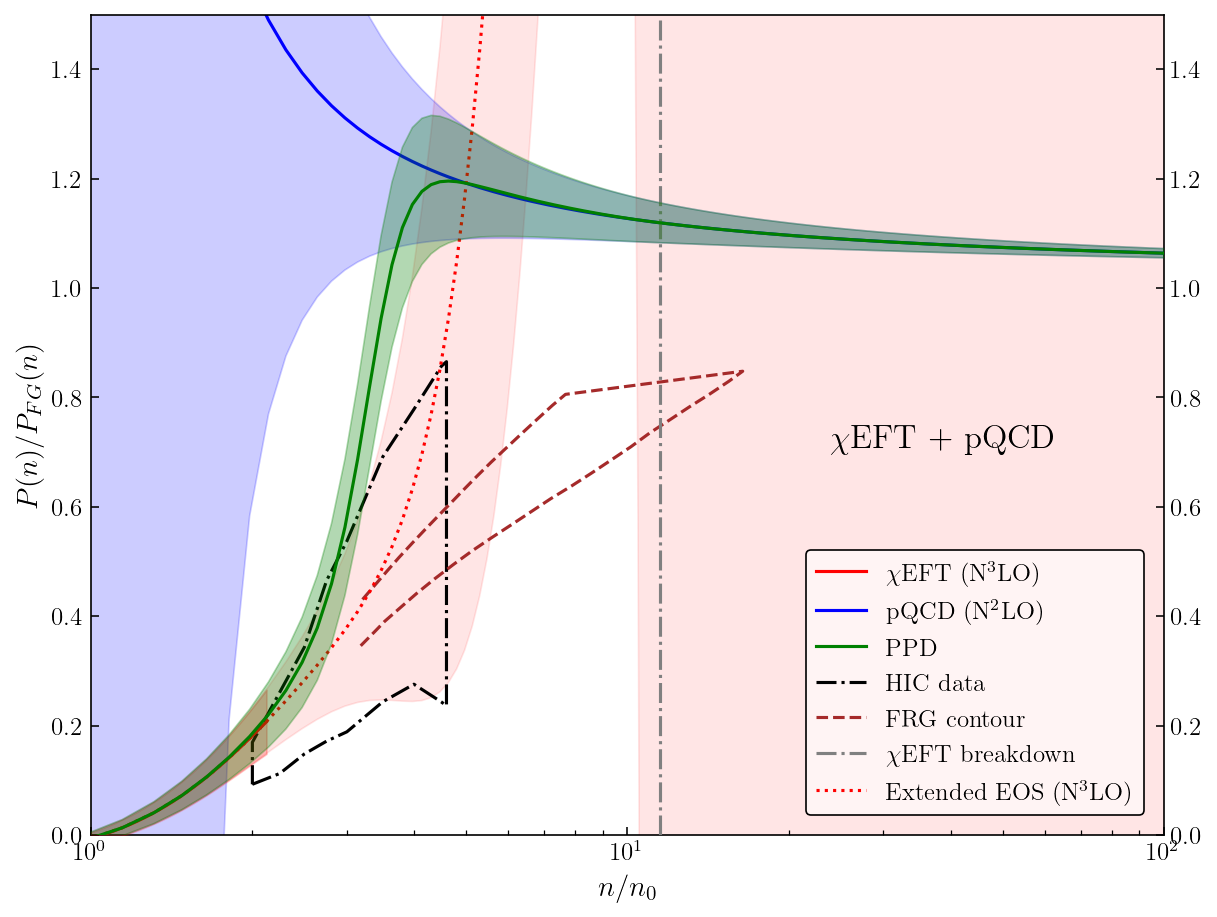

In [21]:
# plot BMM result
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(1., max(density/n0))
ax.set_ylim(0.0,1.5)
ax.tick_params(axis='both', which='major', labelsize=12, labelright=True, right=True)
ax.tick_params(axis='both', which='minor', labelsize=10, labelright=True)
ax.text(0.9,0.5, r'$\chi$EFT + pQCD', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)

colors = ['r', 'b', 'g']
labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed model', \
          r'Extended EOS (N$^{3}$LO)']

# model means
real_chiral = np.load('data/eos_data/pressure_chiral_data_scaled_2n0.npz')
ax.fill_between(real_chiral['density']/n0, real_chiral['mean'][:,3]-real_chiral['std_dev'][:,3], real_chiral['mean'][:,3]+real_chiral['std_dev'][:,3], color='red', zorder=15, alpha=0.2)
ax.plot(real_chiral['density']/n0, real_chiral['mean'][:,3], label=labels[0], color='red', zorder=15)

ax.plot(density/n0, mean_pqcd, color=colors[1], label=labels[1])
#ax.plot(density_test/n0, gp_result['mean'], color='m', label=r'GP')

# PPD mean (testing data array)
ax.plot(density/n0, mixed_mean, color='g', label='PPD', zorder=19)

# model uncertainties
ax.fill_between(density/n0, mean_chiral - 1.0*std_dev_chiral, mean_chiral + 1.0*std_dev_chiral, \
                color=colors[0], alpha=0.1)
ax.fill_between(density/n0, mean_pqcd - 1.0*std_dev_pqcd, mean_pqcd + 1.0*std_dev_pqcd, \
                color=colors[1], alpha=0.2)
#ax.fill_between(density_test/n0, gp_result['mean']-1.0*gp_result['std'], gp_result['mean']+1.0*gp_result['std'], color='m', alpha=0.2)

# PPD band (testing data array)
ax.fill_between(density/n0, mixed_mean-1.0*mixed_std_dev, mixed_mean+1.0*mixed_std_dev,
                        zorder=18, facecolor='g', edgecolor='g', alpha=0.3)

# import contours and plot
df = pd.read_csv('data/contour_scaled.csv')
df_frg = pd.read_csv('data/frg_data_pressure.csv')
df_hhic = pd.read_csv('data/hic_data_huth.csv')
df_hfrg = pd.read_csv('data/frg_data_huth.csv')

# frg unscaling
pressure_free = np.zeros([len(df_frg['n/n0'])])
p_fg = np.zeros([len(density)])
hbarc = 197.327 # MeV fm

# contour kf_s calculated here 
from nuclear_matter import fermi_momentum, nuclear_density
contour_kf_s_fg = fermi_momentum(density=density, degeneracy=4)
contour_kf_s = fermi_momentum(density=0.16*df_frg['n/n0'], degeneracy=4)
for i in range(len(df_frg['n/n0'])):
    pressure_free[i] = ((1.0/(2.0*np.square(np.pi)))*(contour_kf_s[i]**4.0))*(hbarc)
for i in range(len(density)):
    p_fg[i] = ((1.0/(2.0*np.square(np.pi)))*(contour_kf_s_fg[i]**4.0))*(hbarc)
    
# unscale FRG
frg_unscaled = df_frg['P/P_free']*pressure_free
ax.plot(df['Density/n0'], df['p_pfg'], color='k', linestyle='dashdot', label='HIC data')
ax.plot(df_frg['n/n0'], df_frg['P/P_free'], color='brown', linestyle='dashed', label='FRG contour')

# breakdown location of chiral EFT
ax.axvline(x=1.84/n0, color='grey', linestyle='dashdot', zorder=10, label=r'$\chi$EFT breakdown')

# fake chiral
ax.plot(density/n0, mean_chiral, linestyle='dotted', color=colors[0], label=labels[3])

# legend
ax.set_xscale('log')
ax.legend(loc='lower right', fontsize=12)
plt.show()

#print(mean_pqcd-mixed_mean)

## Speed of sound calculation, $c_{s}^{2}(n)$ <a id="cs2_taweret"></a>

We need to extract the speed of sound from the pressure equation. The most direct way to do this is to integrate the $P(n)$ curve to get the energy density. 

$$
P(n) = n^{2} \frac{\partial (\varepsilon/n)}{\partial n}
$$

$$
\varepsilon(n) = n \left[\int_{min(n)}^{n} \frac{P(n)}{n^{2}} dn + \frac{\varepsilon(min(n))}{min(n)} \right],
$$

where $min(n)$ is 0.05 fm$^{-3}$, and $max(n)$ is 16.0 fm$^{-3}$.

After we achieve the energy density in this manner, we will then code the chemical potential as

$$
\mu = \frac{P(n) + \varepsilon(n)}{n},
$$

and finally obtain the speed of sound, given as

$$
c_{s}^{2}(n) = \frac{\partial P}{\partial n } / \frac{\partial \varepsilon}{\partial n} = \frac{1}{\mu} \frac{\partial P(n)}{\partial n}.
$$

(600,)


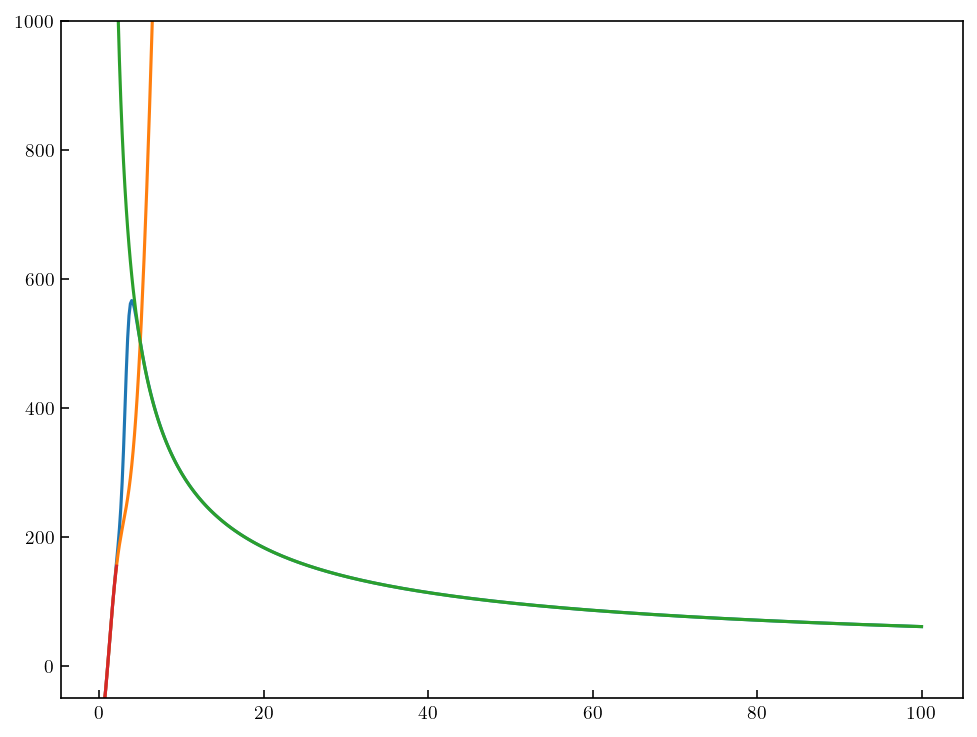

At 100*n0 for the mixed model, we get:  47637.52750259489


In [22]:
density_test = density

edens_data = np.load('data/eos_data/edens_data_chiral.npz')

print(edens_data['density'].shape)

# call the energy density data set and interpolate
edens_interp = scinterp.interp1d(edens_data['density'], edens_data['mean'], kind='cubic', fill_value='extrapolate')
edens_interp_std = scinterp.interp1d(edens_data['density'], edens_data['std'], kind='cubic', fill_value='extrapolate')
en_0 = 47637.52750259489        #edens_interp(density[1])  # BC at 100*n0
en_0_lower = 47505.507238020364 #en_0 - edens_interp_std(density[1])
en_0_upper = 47769.54772653198  #en_0 + edens_interp_std(density[1])

p_mean_interp = scinterp.interp1d(density_test[1:], (mixed_mean[1:]*p_fg[1:]), kind='cubic', fill_value='extrapolate')
p_lower_interp = scinterp.interp1d(density_test[1:], ((mixed_mean[1:]-mixed_std_dev[1:])*p_fg[1:]), kind='cubic', fill_value='extrapolate')
p_upper_interp = scinterp.interp1d(density_test[1:], ((mixed_mean[1:]+mixed_std_dev[1:])*p_fg[1:]), kind='cubic', fill_value='extrapolate')

def p_mean(n):
    return p_mean_interp(n) / (n)**2.0
def p_lower(n):
    return p_lower_interp(n) / (n)**2.0
def p_upper(n):
    return p_upper_interp(n) / (n)**2.0

# interpolation for the real chiral curve to get back the true result
p_fg_interp = scinterp.interp1d(density_test[1:], p_fg[1:], kind='cubic', fill_value='extrapolate')

# plot the function (how bad is it)
plt.plot(density_test[1:]/n0, p_mean(density_test[1:]))
plt.plot(density_test[1:]/n0, mean_chiral[1:]*p_fg[1:]/(density_test[1:]**2.0))
plt.plot(density_test[1:]/n0, mean_pqcd[1:]*p_fg[1:]/(density_test[1:]**2.0))
plt.plot(real_chiral['density'][1:]/n0, (real_chiral['mean'][1:,3]*p_fg_interp(real_chiral['density'][1:])/(real_chiral['density'][1:]**2.0)))
plt.ylim(-50., 1000.)
plt.show()

# pressure dict for input
pres = {
    'mean': (mixed_mean*p_fg)[1:],
    'std_dev': (mixed_std_dev*p_fg)[1:]
}

# edens dict for input
edens = {
    'mean': en_0,
    'lower': en_0_lower,
    'upper': en_0_upper
}

dens_cs2, cs2_result, _, edens_result, _= speed_of_sound(density[1:], pres, edens, \
                                                 sat=False, integrate='backward')
cs2_mean = cs2_result['mean']
cs2_lower = cs2_result['lower']
cs2_upper = cs2_result['upper']

print('At 100*n0 for the mixed model, we get: ', edens_result['mean'][-1])

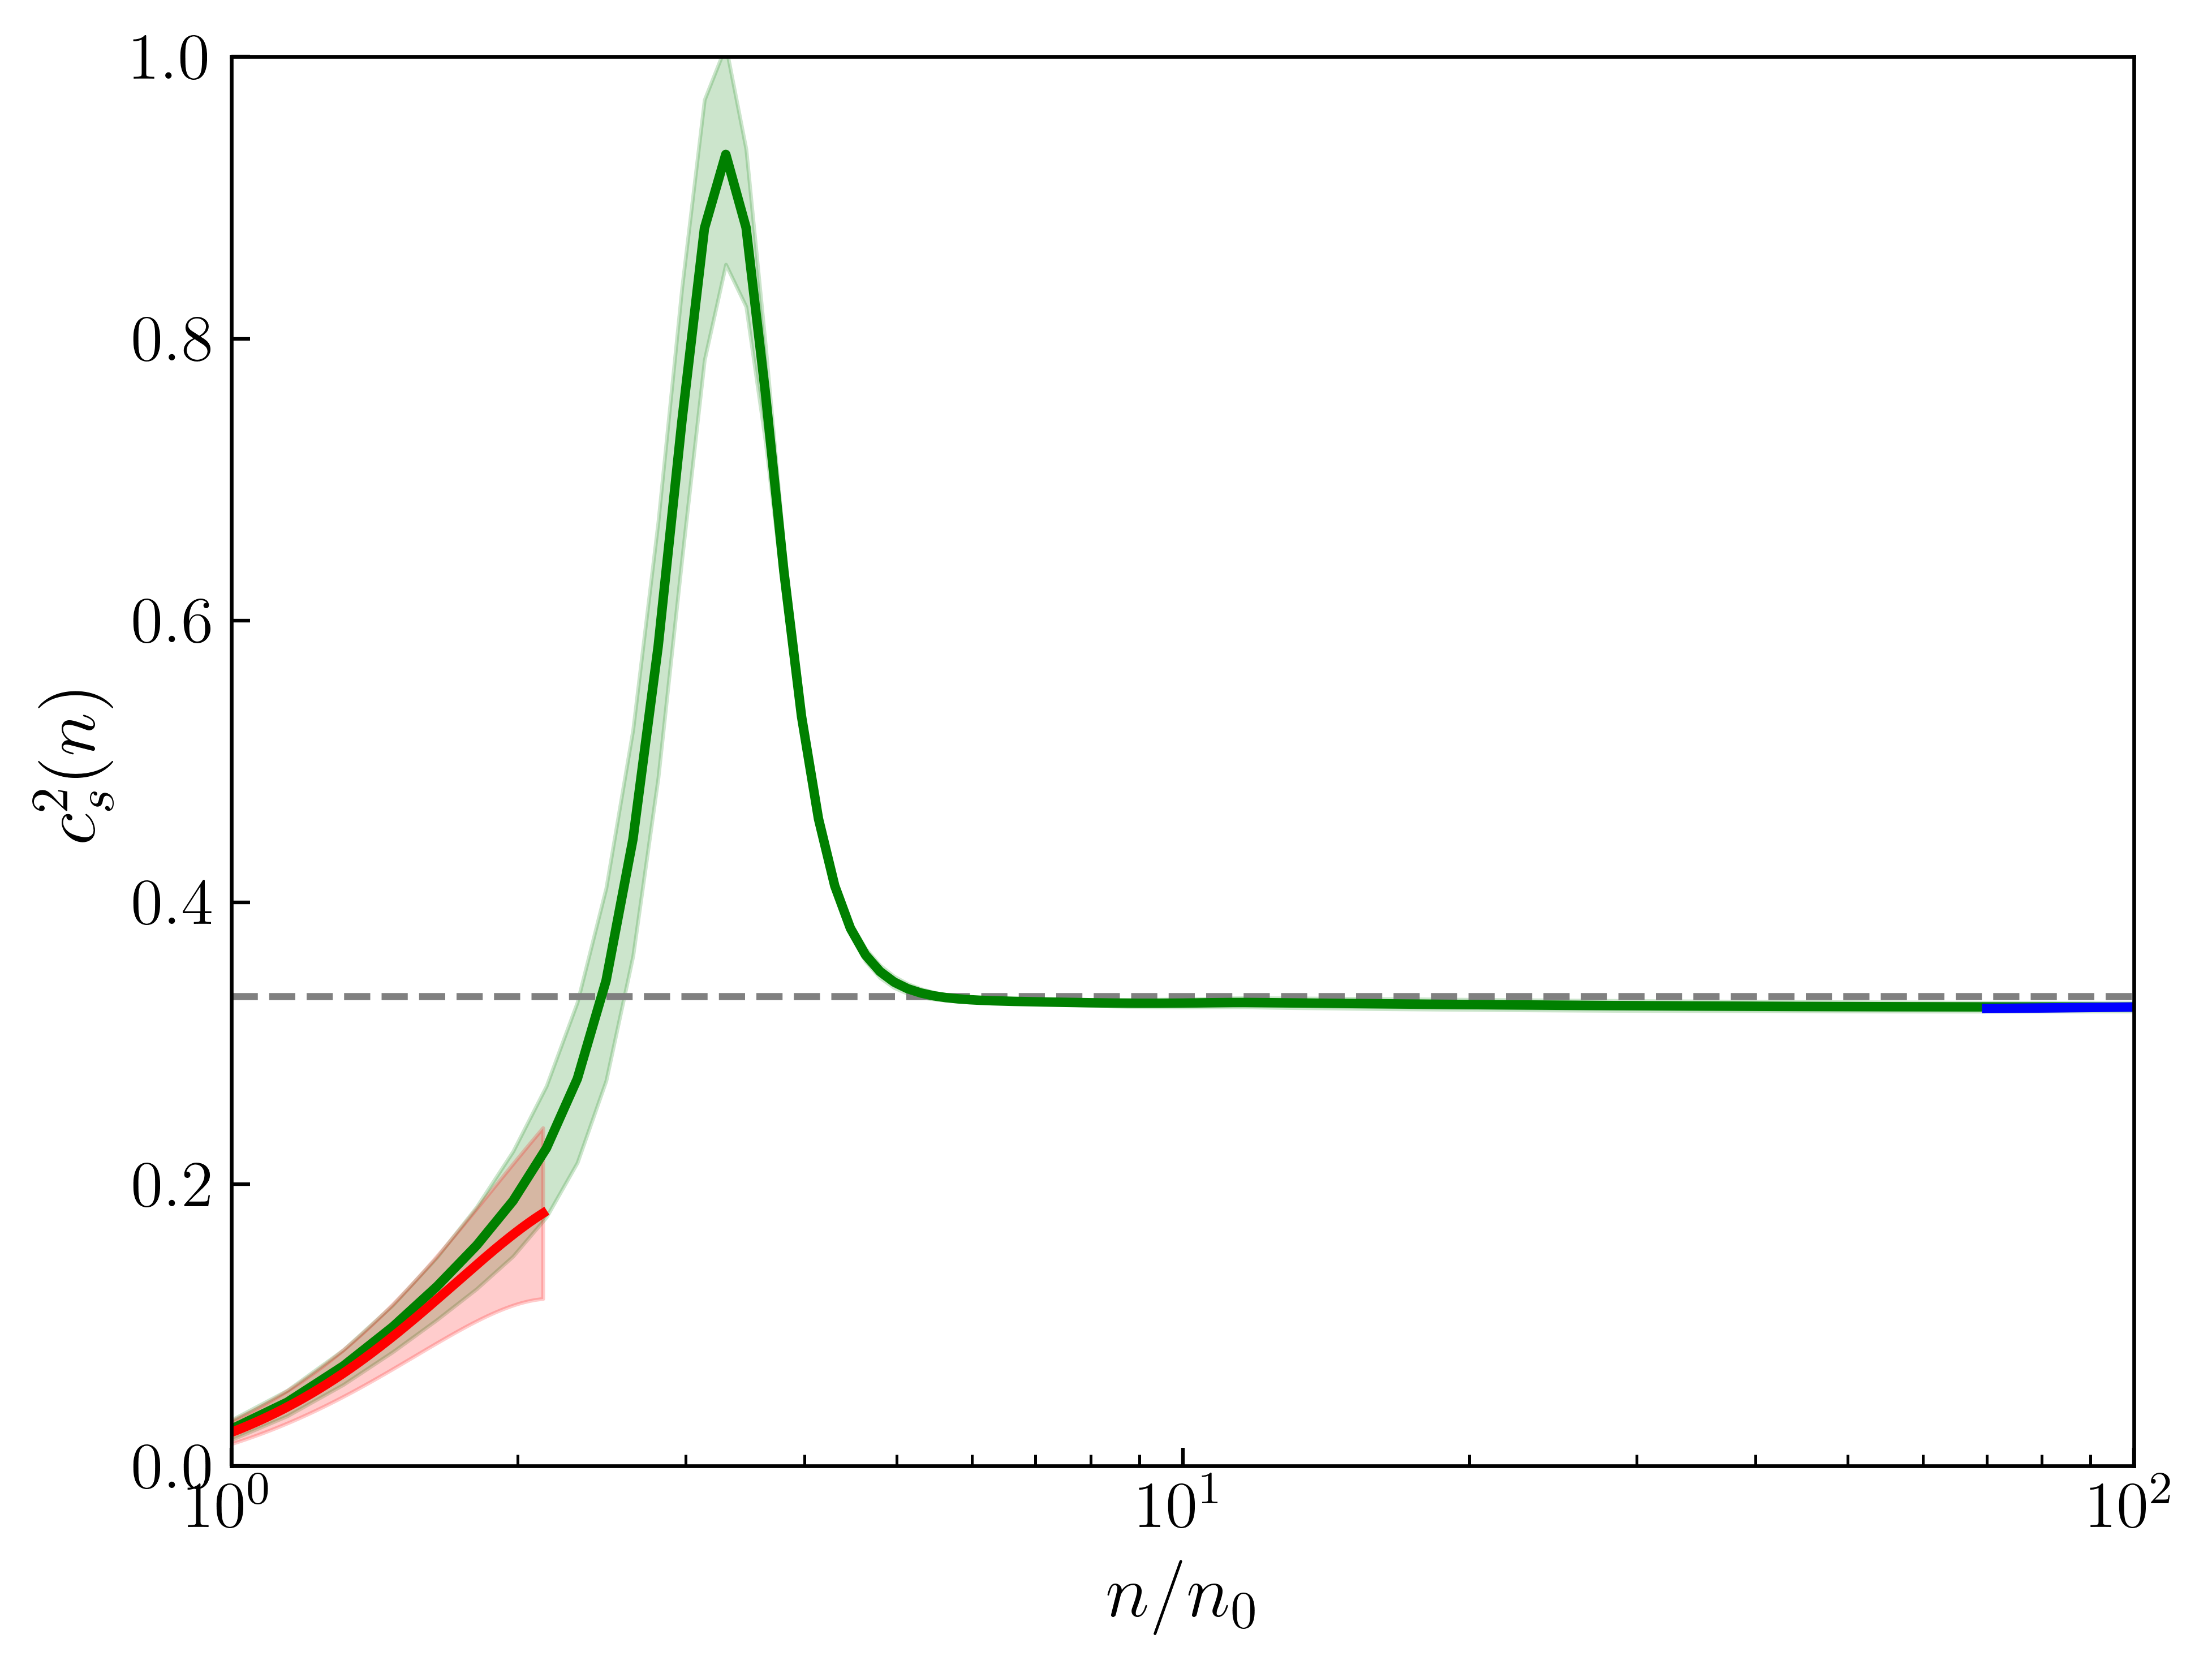

0.32571624561217605 0.32573117167497345
75.61872909698997


In [23]:
# plot the result quickly (noting the issue with scaling back out of P/P_FG)
mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi'] = 600   # change for paper plots
mpl.rcParams['font.size'] = 8
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
WIDE_IMG_WIDTH = 800
NARROW_IMG_WIDTH = 400

plt.axhline(y=0.333333, color='grey', linestyle='dashed')

plt.plot(dens_cs2/n0, cs2_mean, color='g', linewidth=2, label=r'Mixed model')
plt.fill_between(dens_cs2/n0, cs2_lower, cs2_upper, color='g', alpha=0.2)

# plot the result from chiral to see differences
npzfile = np.load('speedofsoundchiral.npz')
chiral_mean = npzfile['mean']
chiral_std = npzfile['std']
chiral_dens = npzfile['density']
plt.plot(chiral_dens/n0, chiral_mean[:,3], color='red', linewidth=2, label=r'ChEFT')
plt.fill_between(chiral_dens/n0, chiral_mean[:,3]+chiral_std[:,3], chiral_mean[:,3]-chiral_std[:,3], alpha=0.2, color='red')

# plot the result from pqcd to see differences
npzfile2 = np.load('data/eos_data/pqcd_cs2_11.2_alphas.npz')
pqcd_cs2 = npzfile2['mean']
pqcd_dens = npzfile2['density']
pqcd_lower = npzfile2['lower']
pqcd_upper = npzfile2['upper']
plt.plot(pqcd_dens/n0, pqcd_cs2, color='blue', linewidth=2, label=r'pQCD')
plt.fill_between(pqcd_dens/n0, pqcd_lower, pqcd_upper, color='blue', alpha=0.2)

# plot individual calculation from pQCD as well (using same method, but no energy density integration)
plt.xlim(1.0, 100.0)
plt.ylim(0.0, 1.0)
plt.xlabel(r'$n/n_{0}$', fontsize=16)
plt.ylabel(r'$c_{s}^{2}(n)$', fontsize=16)
plt.xscale('log')

# set up the labels
#plt.text(0.5,0.5, r'$\chi$EFT', ha='right', va='top', fontsize=16)
plt.show()

print(cs2_mean[-1], pqcd_cs2[-1])
print(pqcd_dens[56]/n0)

## Creating the paper plot: Multivariate Model Mixing

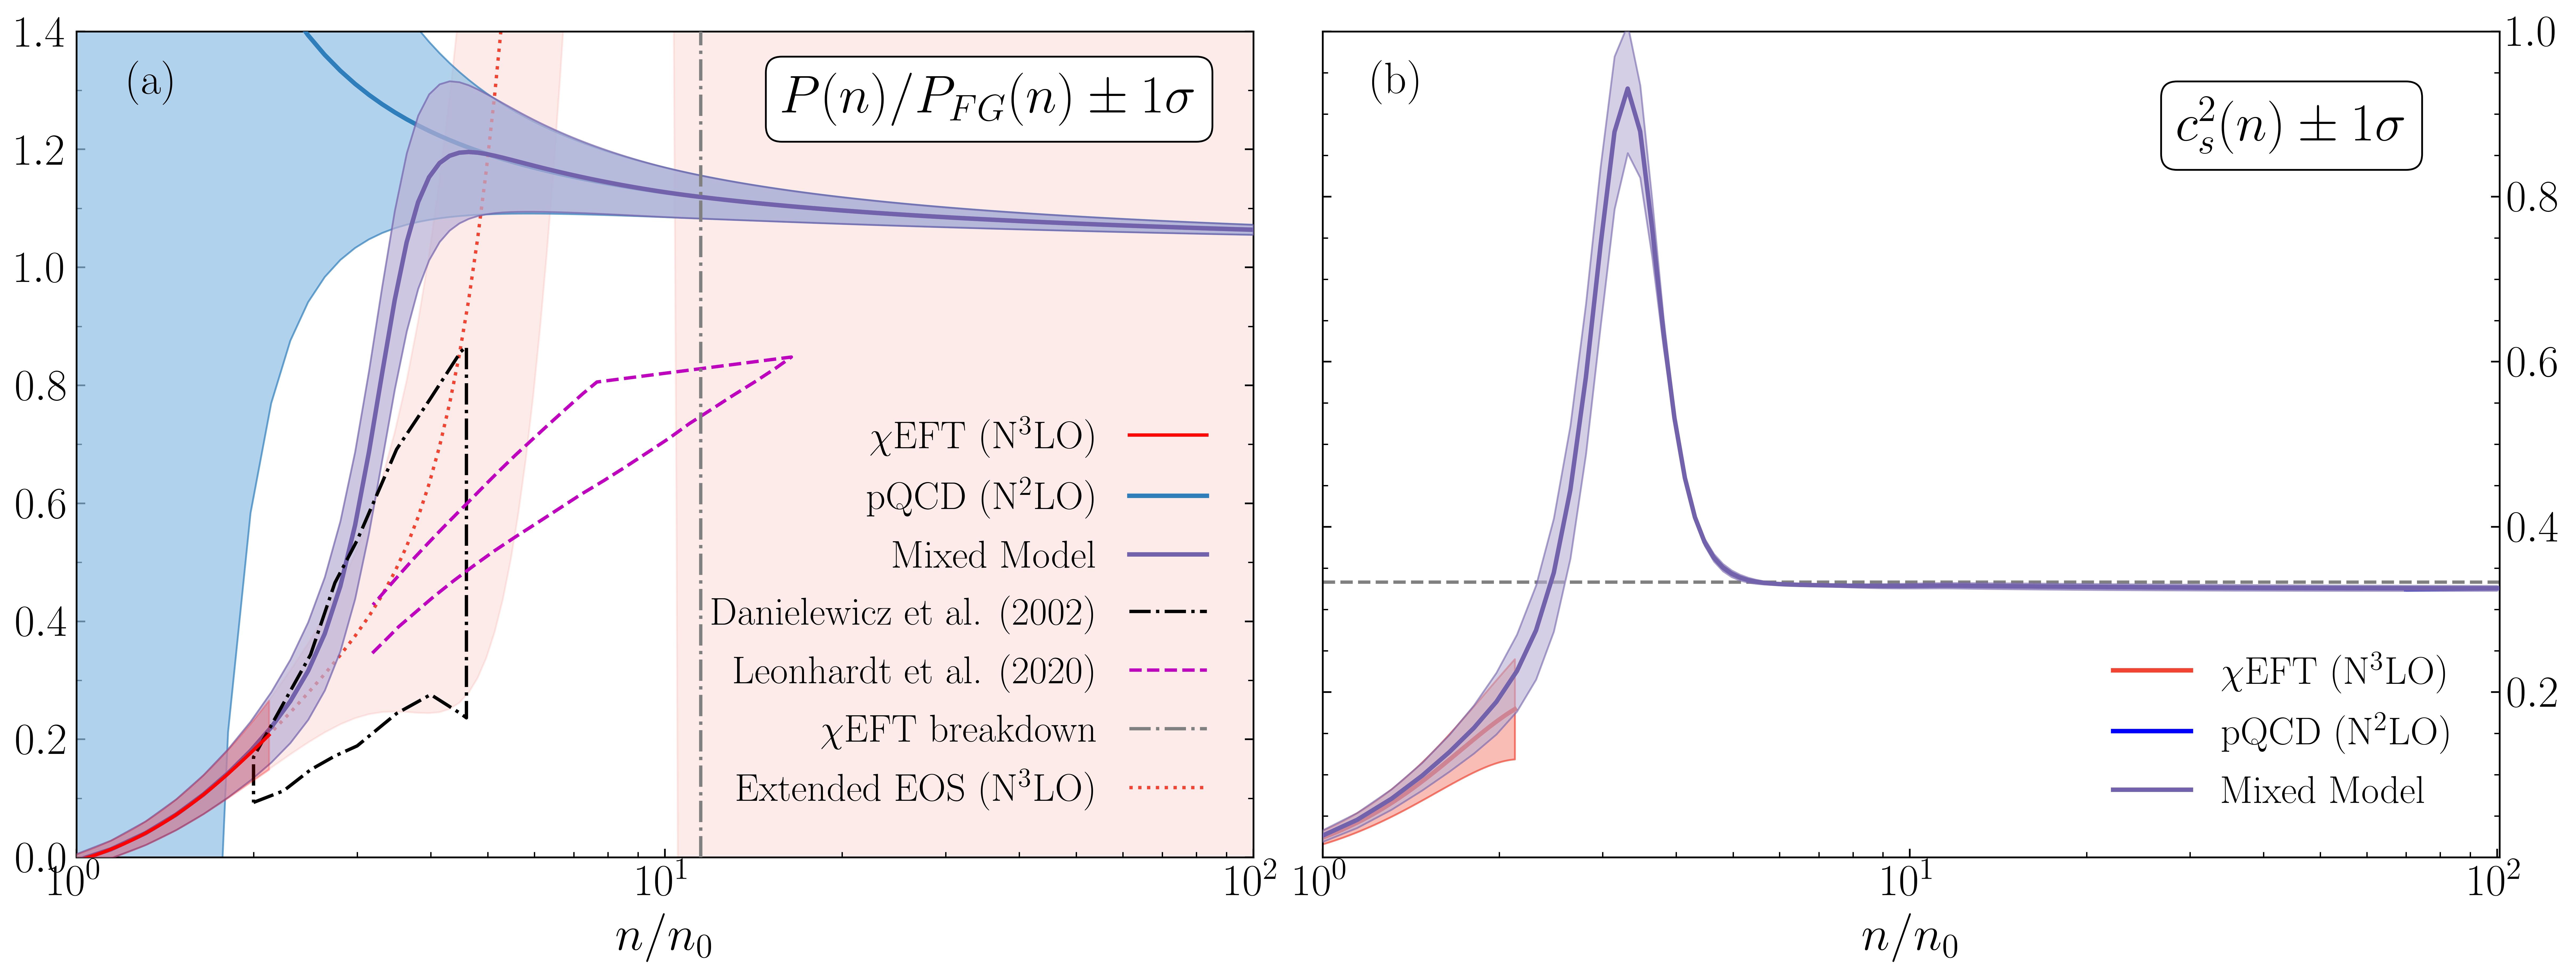

In [12]:
# set up the plot requirements
fig, ax = plt.subplots(1, 2, figsize=(16,6), dpi=600, sharex='col')
#fig.patch.set_alpha(0.0)
ax[0].set_xlim(1.00, max(density/n0))
ax[0].set_ylim(0.0,1.4)
ax[0].tick_params(axis='both', which='major', labelsize=20, right=True)
ax[0].tick_params(axis='both', which='minor', labelsize=20, right=True)
ax[0].xaxis.set_major_locator(MultipleLocator(10))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[0].text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[0].text(1.5, 1.35, r'(a)', ha='right', va='top', fontsize=20)
ax[0].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[0].set_xscale('log')

ax[1].set_xlim(1., max(density/n0)+1.)
ax[1].set_ylim(1e-6,1.0)
ax[1].xaxis.set_major_locator(MultipleLocator(10))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[1].tick_params(axis='both', which='major', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].tick_params(axis='both', which='minor', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].text(
    70.0,0.92, r'$c_{s}^{2}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[1].text(1.5, 0.965, r'(b)', ha='right', va='top', fontsize=20)
ax[1].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[1].set_xscale('log')

orders = [0,1,2]

# plotting assistance
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues', 'Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

# pressure data

# model means and uncertainties
ax[0].fill_between(density/n0, mean_chiral - 1.0*std_dev_chiral, mean_chiral + 1.0*std_dev_chiral, \
                color=colors[0], alpha=0.1)

ax[0].fill_between(real_chiral['density']/n0, real_chiral['mean'][:,3]-real_chiral['std_dev'][:,3], \
                   real_chiral['mean'][:,3]+real_chiral['std_dev'][:,3], color='red', zorder=15, alpha=0.2)

ax[0].plot(real_chiral['density']/n0, real_chiral['mean'][:,3], label=labels[0], color='red', zorder=15)

ax[0].fill_between(density/n0, mean_pqcd - 1.0*std_dev_pqcd, mean_pqcd + 1.0*std_dev_pqcd, \
                facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

ax[0].plot(density/n0, mean_pqcd, zorder=3, linewidth=2, color=colors[1], label=labels[1])

# PPD band (testing data array)
ax[0].fill_between(density/n0, mixed_mean-1.0*mixed_std_dev, mixed_mean+ \
                   1.0*mixed_std_dev,
                       zorder=5, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# PPD mean (testing data array)
ax[0].plot(density/n0, mixed_mean, color=colors[2], zorder=10, linewidth=2, label='Mixed Model')

# frg unscaling
density_test = density
pressure_free = np.zeros([len(df_frg['n/n0'])])
p_fg = np.zeros([len(density_test)])
hbarc = 197.327 # MeV fm

# contour kf_s calculated here
contour_kf_s_fg = fermi_momentum(density=density_test, degeneracy=4)
contour_kf_s = fermi_momentum(density=0.16*df_frg['n/n0'], degeneracy=4)

for i in range(len(df_frg['n/n0'])):
    pressure_free[i] = ((1.0/(2.0*np.square(np.pi)))*(contour_kf_s[i]**4.0))*(hbarc)
p_fg = pqcd_convert_arr
    
# unscale FRG
frg_unscaled = df_frg['P/P_free']*pressure_free
ax[0].plot(df['Density/n0'], df['p_pfg'], color='black', linestyle='dashdot', zorder=10, label='Danielewicz et al. (2002)')
ax[0].plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', zorder=10, label='Leonhardt et al. (2020)')

# breakdown location of chiral EFT
ax[0].axvline(x=1.84/n0, color='grey', linestyle='dashdot', zorder=10, label=r'$\chi$EFT breakdown')

# fake chiral
ax[0].plot(density/n0, mean_chiral, linestyle='dotted', color=colors[0], label=labels[3])

# legend
ax[0].legend(loc='lower right', facecolor='w', markerfirst=False, frameon=False, fontsize=17.5)

# speed of sound data 
ax[1].axhline(y=(1.0/3.0), color='grey', linestyle='dashed')  # conformal limit

# plot the result from chiral to see differences
npzfile = np.load('speedofsoundchiral.npz')
chiral_mean = npzfile['mean'][:,3]
chiral_std = npzfile['std'][:,3]
chiral_dens = npzfile['density']
ax[1].fill_between(chiral_dens/n0, chiral_mean-1.0*chiral_std, \
                 chiral_mean+1.0*chiral_std, alpha=0.7, zorder=0, \
                   facecolor=light_colors[0], edgecolor=colors[0])
ax[1].plot(chiral_dens/n0, chiral_mean, color=colors[0], zorder=1, linewidth=2, \
           label=r'$\chi$EFT (N$^3$LO)')

# plot the result from pqcd to see differences
npzfile2 = np.load('data/eos_data/pqcd_cs2_11.2_alphas.npz')
pqcd_cs2 = npzfile2['mean']
pqcd_dens = npzfile2['density']
pqcd_lower = npzfile2['lower']
pqcd_upper = npzfile2['upper']
ax[1].fill_between(pqcd_dens/n0, pqcd_lower, pqcd_upper, zorder=2, \
                   facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)
ax[1].plot(pqcd_dens/n0, pqcd_cs2, color='blue', linewidth=2, zorder=3, label=r'pQCD (N$^2$LO)')

# mixed model cs2 data
ax[1].fill_between(dens_cs2/n0, cs2_lower, cs2_upper, zorder=4, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.6)
ax[1].plot(dens_cs2/n0, cs2_mean, color=colors[2], linewidth=2, zorder=5, label=r'Mixed Model')

ax[1].legend(loc='lower right', facecolor='w', frameon=False, fontsize=17.5)
plt.show()
#fig.savefig('subplot_pointwise_model_alphas.PNG', bbox_inches='tight')